In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

! pip install gradio
import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import socket, warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(("1.1.1.1", 53))
except socket.error as ex: raise Exception("STOP")

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow

In [5]:
! pip install fastbook
! [ -e /content ] && pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 1.9 MB/s eta 0:00:0000:0100:01


In [6]:
import fastbook
fastbook.setup_book()

In [7]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [8]:
from duckduckgo_search import ddg_images

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [9]:
searches = 'moose', 'deer', 'elk'
path = Path('trail_cam')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls = search_images(f'{o} trail cam photo'))
    sleep(10)
    download_images(dest, urls = search_images(f'{o} trail cam photo day'))
    sleep(10)
    download_images(dest, urls = search_images(f'{o} trail cam photo night'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'moose trail cam photo'
Searching for 'moose trail cam photo day'
Searching for 'moose trail cam photo night'
Searching for 'deer trail cam photo'
Searching for 'deer trail cam photo day'
Searching for 'deer trail cam photo night'
Searching for 'elk trail cam photo'
Searching for 'elk trail cam photo day'
Searching for 'elk trail cam photo night'


In [10]:
fns = get_image_files(path)
len(fns)

856

In [11]:
failed = verify_images(fns)
failed.map(Path.unlink)

len(failed)

12

In [25]:
from PIL import Image

deers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.2 , seed = 42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms=aug_transforms()
)


dls = deers.dataloaders(path)

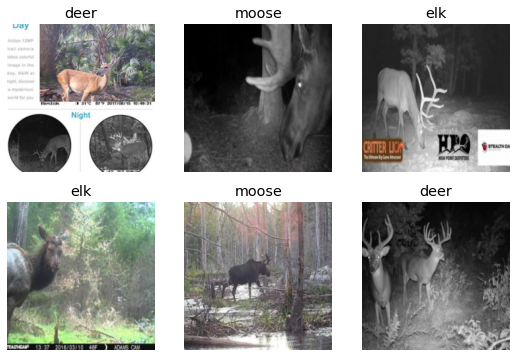

In [26]:
dls.valid.show_batch(max_n=6, nrows=2)

In [27]:
learn = vision_learner(dls, models.resnet34, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.716120,0.866728,0.369048,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.245711,0.677479,0.244048,00:07
1,1.155060,0.730329,0.261905,00:06
2,1.000110,0.750360,0.267857,00:06
3,0.863580,0.741090,0.285714,00:06
4,0.801608,0.713191,0.279762,00:07


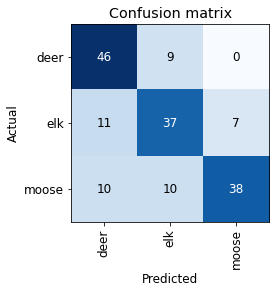

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

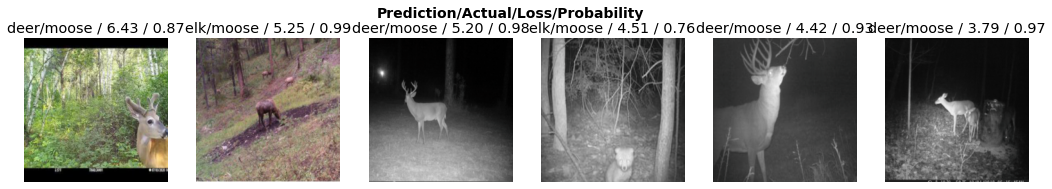

In [29]:
interp.plot_top_losses(6, nrows=1)

In [30]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [31]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
    
dls = deers.dataloaders(path)

In [32]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.693449,1.041595,0.395210,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.163644,0.988442,0.383234,00:06
1,1.026127,1.023041,0.347305,00:06
2,0.867799,0.950581,0.269461,00:07
3,0.764119,0.932010,0.263473,00:06
4,0.667500,0.906717,0.257485,00:06


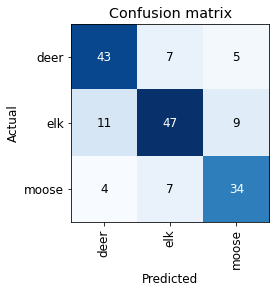

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [34]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [35]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
    
dls = deers.dataloaders(path)

In [36]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.756558,0.803191,0.349398,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.167884,0.638642,0.253012,00:06
1,1.072628,0.556600,0.180723,00:06
2,0.977297,0.695778,0.216867,00:07
3,0.830755,0.608140,0.198795,00:06
4,0.715023,0.643525,0.192771,00:06
5,0.646352,0.591635,0.174699,00:06
6,0.582057,0.613607,0.210843,00:06
7,0.522445,0.624848,0.198795,00:07
8,0.471340,0.629954,0.204819,00:06
9,0.446069,0.619919,0.204819,00:06


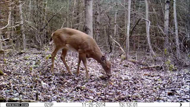

In [50]:
from fastdownload import download_url
urls = search_images_ddg('trail cam deer')
urls[0]
download_url(urls[0], 'deer.jpg')

im = Image.open('deer.jpg')
im.to_thumb(190,190)

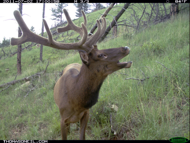

In [48]:
urls = search_images_ddg('trail cam elk')
urls[0]
download_url(urls[0], 'elk.jpg')

im = Image.open('elk.jpg')
im.to_thumb(190,190)

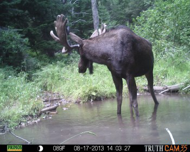

In [39]:
urls = search_images_ddg('trail cam moose')
urls[1]
download_url(urls[1], 'moose.jpg')

im = Image.open('moose.jpg')
im.to_thumb(190,190)

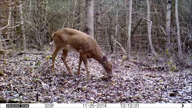

In [51]:
im = PILImage.create("deer.jpg")
im.thumbnail((192, 192))
im

In [52]:
learn.predict(im)

('deer', TensorBase(0), TensorBase([0.4069, 0.3449, 0.2482]))

# Pickel and export model to be uploaded to gradio

In [ ]:
learn.path = Path('.')
learn.export('new_model.pkl')

In [52]:
from fastai.vision.all import *
import gradio as gr

learn = load_learner('new_model.pkl')
categories = learn.dls.vocab

def classify_image(img):
    img = PILImage.create(img)
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))


In [54]:
image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
examples = ['deer.jpg', 'elk.jpg', 'moose.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False, share=True)

/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/opt/conda/lib/python3.7/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://22892.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7fa188e25110>,
 'http://127.0.0.1:7863/',
 'https://22892.gradio.app')